In [1]:
import pandas as pd
import sys

In [2]:
from src.utils.tree import SNPTreeParser
from src.utils.analysis import EpistasisFinder

In [3]:
bfile = 'path_to_your_genotype' # prefix for PLINK bfile ("https://www.cog-genomics.org/plink/1.9/input")
ont = 'path_to_ontology_file.txt'
snp2gene = 'path_to_snp2gene_file.txt'

In [4]:
tree_parser = SNPTreeParser(ont, snp2gene, sys_annot_file='GO_files/goID_2_name.tab')

2227 Systems are queried
963 Genes are queried
Total 9646 Gene-System interactions are queried
Building descendant dict
Subtree types:  ['default']


In [5]:
attention_result = 'path_to_attention_result_from_your_G2PT_prediction'

In [6]:
cov = 'path_to_covariate_file' # PLINK Covar file https://www.cog-genomics.org/plink/1.9/input
pheno = 'path_to_pheno_file' # PLINK Pheno file https://www.cog-genomics.org/plink/1.9/input

In [7]:
epistasis_finder = EpistasisFinder(tree_parser, bfile, attention_results=attention_result, cov=cov, pheno=pheno, flip=True)

Swapping Ref and Alt!
From PLINK 4019 variants with 317007 samples are queried


In [8]:
target_system = 'GO:0015721'

# 1. Epistasis Search in Target System

In [9]:
# set verbose=1 if you want to detailed statistical result (not recommended for large system)
epistasis_results, snp_inheritance = epistasis_finder.search_epistasis_on_system(target_system, sex=0, quantile=0.9, verbose=0) 

System: GO:0015721, Sex: 0
Check Inheritance
Running Chi-Square Test...
	Testing 22 SNPs on 17172 risky individuals
	From 22 SNPs, 22 SNPs pass Chi-Square test
Running Fisher
	From 231.0 significant pairs, 98 pairs pass Fisher test
Filtering Close SNPs
	From 98 pairs, close 10 SNP pairs are removed
Calculating statistical Interaction p-value 
	Testing 21 SNPs on 171712 individuals, SNPs in system ()
	From 88 pairs, 9 significant interaction are queried


In [11]:
epistasis_results_with_genes = []

for snp_1, snp_2, p_val, p_val_adjusted in epistasis_results:
    gene1 = [gene for gene in tree_parser.snp2gene[snp_1] if gene in tree_parser.sys2gene_full[target_system]]
    gene2 = [gene for gene in tree_parser.snp2gene[snp_2] if gene in tree_parser.sys2gene_full[target_system]]
    gene_product_list = [(x, y) for x in gene1 for y in gene2]
    for g1, g2 in gene_product_list:
        epistasis_results_with_genes.append((snp_1, g1,  snp_2, g2, p_val, p_val_adjusted))
        print(snp_1, g1,  snp_2, g2, p_val, p_val_adjusted)

12:21391352:G:A SLCO1B1 1:27215079:T:C NR0B2 0.0023868051398129877 0.044946051545104476
12:21352315:A:G SLCO1B1 1:27215079:T:C NR0B2 0.00020210318800223178 0.008892540272098199
12:21391608:A:G SLCO1B1 1:27215079:T:C NR0B2 0.002553752928699118 0.044946051545104476
12:21331549:T:C SLCO1B1 1:27215079:T:C NR0B2 0.0006015898274226132 0.01764663493772999
12:21391352:G:A SLCO1B1 1:27234682:G:A NR0B2 0.00463052918672207 0.048755832662880416
12:21352315:A:G SLCO1B1 1:27234682:G:A NR0B2 0.004207345934138964 0.048755832662880416
12:21391608:A:G SLCO1B1 1:27234682:G:A NR0B2 0.004986391976885498 0.048755832662880416
12:21352541:A:G SLCO1B1 1:27215079:T:C NR0B2 0.00017240908154806815 0.008892540272098199
12:21352541:A:G SLCO1B1 1:27234682:G:A NR0B2 0.0034931002245380434 0.048755832662880416


# 2. Epistasis Visualization

## 2.1 Epistatic interaction plots

put SNP pairs from your epistatic results

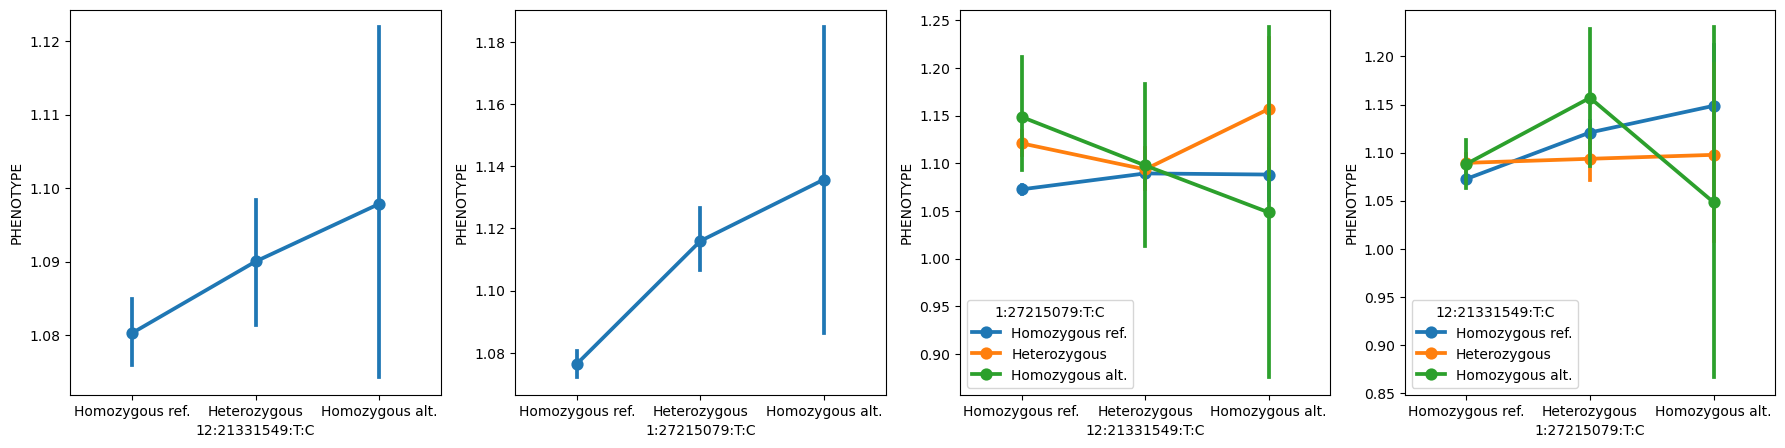

In [12]:
epistasis_finder.draw_epistasis('12:21331549:T:C', '1:27215079:T:C', phenotype='PHENOTYPE', sex=0) # put out_dir='path_to_save' to save figure as svg

## 2.2 Epistatic Sub-hierarchy Visualization

You can visualize epistasis under the target system

In [13]:
from src.utils.visualization.epistasis import EpistasisVisualizer

In [14]:
epistasis_visualizer = EpistasisVisualizer(tree_parser)

In [15]:
epistasis_results_genes = [[gene1, gene2] for snp1, gene1, snp2, gene2, p_val, adjusted_p_val in epistasis_results_with_genes]

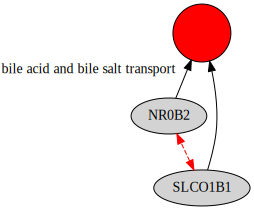

In [16]:
epistasis_visualizer.visualize_epistasis(target_system=target_system, epistatic_interactions=epistasis_results_genes)

# 3. Epistasis Analysis Result using LLM

In [17]:
from src.utils.analysis.llm_explainer import EpistaticInteractionExplainer

In [18]:
OPENAI_API_KEY = 'your_open_ai_api_key'

In [19]:
epistasis_explainer = EpistaticInteractionExplainer(OPENAI_API_KEY, model='chatgpt-4o-latest')

Put your target system, phenotype, and target genes

In [24]:
llm_result = epistasis_explainer.explain_epistasis(tree_parser.sys_annot_dict[target_system], 'TG/HDL ratio', 'NR0B2', 'SLCO1B1')

Print out epistasis analysis from LLM

In [21]:
from IPython.display import Markdown as md

In [25]:
md(llm_result)

### **Analysis of Epistatic Interaction Between NR0B2 and SLCO1B1 in Bile Acid and Bile Salt Transport**

#### **1. Biological Roles of NR0B2 and SLCO1B1 in Bile Acid and Bile Salt Transport**

- **NR0B2 (Nuclear Receptor Subfamily 0 Group B Member 2, also known as SHP)**  
  NR0B2 is an orphan nuclear receptor that functions as a transcriptional repressor. It plays a critical role in bile acid homeostasis by inhibiting the transcriptional activity of other nuclear receptors, such as **FXR (Farnesoid X Receptor)**, which regulates genes involved in bile acid synthesis, transport, and metabolism. Through this repression, NR0B2 helps regulate bile salt production and prevents excessive bile acid accumulation that could be toxic to cells.

- **SLCO1B1 (Solute Carrier Organic Anion Transporter Family Member 1B1, also known as OATP1B1)**  
  SLCO1B1 is a membrane transporter primarily expressed in hepatocytes. It facilitates the hepatic uptake of bile acids, bile salts, and various endogenous and exogenous organic anions, including statins. By mediating the clearance of bile acids from circulation, SLCO1B1 plays an essential role in maintaining bile acid homeostasis and preventing systemic toxicity.

#### **2. Interaction and Influence on the TG/HDL Ratio Phenotype**

The **TG/HDL ratio (triglyceride-to-high-density lipoprotein cholesterol ratio)** is an important biomarker for metabolic health, lipid metabolism, and cardiovascular disease risk. 

- **NR0B2 and Lipid Metabolism:**  
  NR0B2 indirectly influences the TG/HDL ratio by regulating bile acid levels, which in turn affect lipid digestion and cholesterol metabolism. It suppresses genes involved in bile acid synthesis, thereby influencing lipid absorption and transport.

- **SLCO1B1 and Lipid Metabolism:**  
  SLCO1B1 facilitates the hepatic uptake of bile acids, which are important for emulsifying dietary fats and regulating lipid metabolism. Variants in **SLCO1B1** have been associated with altered lipid profiles, affecting the TG/HDL ratio.

- **Potential Interaction Impact:**  
  If NR0B2 is dysfunctional, bile acid synthesis may increase, potentially altering lipid absorption and leading to dysregulated triglyceride (TG) and HDL levels. If **SLCO1B1 is impaired**, bile acid clearance from circulation may be reduced, further disrupting lipid metabolism. Together, their interaction could exacerbate dyslipidemia, influencing the **TG/HDL ratio** by increasing TG levels and lowering HDL.

#### **3. Possible Epistatic Relationships**

- **Suppression (Epistasis by Compensation):**  
  If NR0B2 is dysfunctional, leading to excessive bile acid synthesis, increased SLCO1B1 activity might compensate by enhancing bile acid clearance, partially mitigating lipid dysregulation. Conversely, if **SLCO1B1 is impaired**, NR0B2-mediated suppression of bile acid synthesis might help prevent excessive bile acid accumulation.

- **Redundancy (Buffering Epistasis):**  
  If both genes contribute to bile acid regulation independently, loss of one gene might not lead to severe phenotypic effects unless the other is also lost. This would indicate functional redundancy in bile acid transport and metabolism.

- **Synthetic Lethality (Severe Dysfunction When Both Are Mutated):**  
  If both NR0B2 and SLCO1B1 are disrupted, bile acid homeostasis could collapse, leading to severe metabolic dysfunction, toxic bile acid accumulation, and increased cardiovascular risk due to extreme dyslipidemia.

#### **4. Predicted Phenotypic Effects of Gene Perturbations**

| **Perturbation** | **Predicted Effect on Bile Acid Transport** | **Predicted Effect on TG/HDL Ratio** |
|-----------------|---------------------------------|--------------------------|
| **NR0B2 Loss** | Increased bile acid synthesis | Increased TG, decreased HDL |
| **SLCO1B1 Loss** | Impaired hepatic bile acid uptake | Increased TG, decreased HDL |
| **NR0B2 & SLCO1B1 Loss (Double Mutation)** | Severe bile acid dysregulation | Exacerbated dyslipidemia, extreme TG/HDL imbalance, increased cardiovascular risk |

#### **Conclusion**
NR0B2 and SLCO1B1 interact in bile acid homeostasis, contributing to lipid metabolism regulation. Their relationship may exhibit **suppressive or buffering epistasis**, where the loss of one gene could be partially compensated by the other. However, **double-gene loss may lead to severe metabolic dysfunction**. Understanding their interaction is crucial for assessing metabolic disease risks and therapeutic interventions, particularly in lipid disorders and cardiovascular health.

**You can also visualize llm analysis as diagram!**

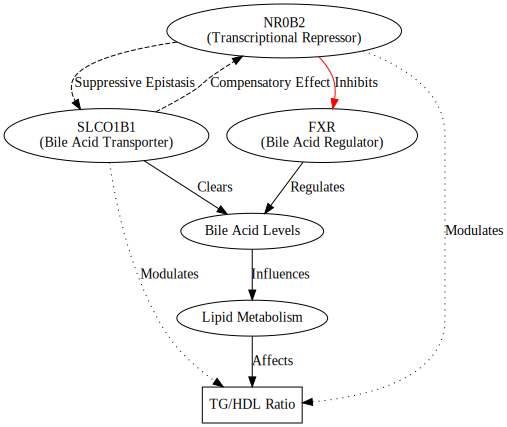

In [26]:
epistasis_explainer.visualize_epistasis_from_llm_analysis(llm_result)